- [Project Overview](#Project-Overview)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Load and Explore Data](#Load-and-Explore-Data)
    - [Statistics and visualization](#Statistics-and-visualization)
    - [Data preparation](#Data-preparation)
- [Modeling](#Modeling)
  - [Finding the best model](#Finding-the-best-model)
  - [Comparison of boosting models](#Comparison-of-boosting-models)
  - [MLP(multilayer perceptron)](#MLP(multilayer-perceptron))
  - [Interpretation and optimization](#Interpretation-and-optimization)
  - [The best configuration](#The-best-configuration)
- [Model quality assessment](#Model-quality-assessment)
  - [Model metrics](#Model-metrics)
  - [Business effect evaluation](#Business-effect-evaluation)
- [Final Summary](#Final-Summary)

# Project Overview

**The company aims to optimize the cold-calling process within a marketing campaign focused on attracting clients to deposit products.
The task is to predict whether a client will agree to open a deposit account after a phone call.**

Solving this problem will help to:
* Reduce the cost of cold calls
* Focus operators efforts on 'warm' (high-potential) clients
* Increase the overall conversion rate and marketing efficiency


***The goal of the project is to build a machine learning model that predicts a client’s likelihood of agreeing to open a deposit based on their personal and campaign-related information.***

The data used in this project comes from the [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing). 
It contains information from direct marketing campaigns (phone calls) carried out by a Portuguese banking institution between May 2008 and November 2010.

# Exploratory Data Analysis

## Load and Explore Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap
import xgboost

from statsmodels.stats.proportion import proportions_ztest
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import (accuracy_score, precision_score, recall_score, precision_recall_curve, auc,
                            confusion_matrix, roc_auc_score, average_precision_score, roc_curve, f1_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df.duplicated().sum()

np.int64(0)

## Statistics and visualization

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


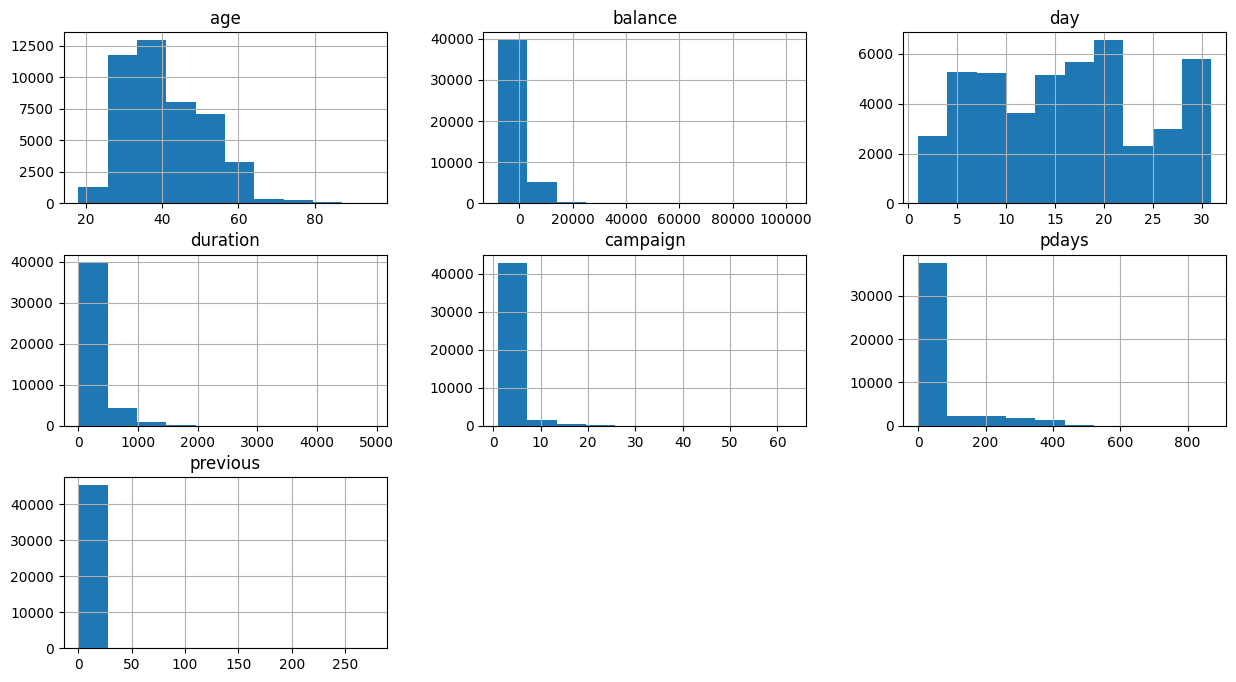

In [28]:
df.hist(figsize=(15, 8));
df.describe()

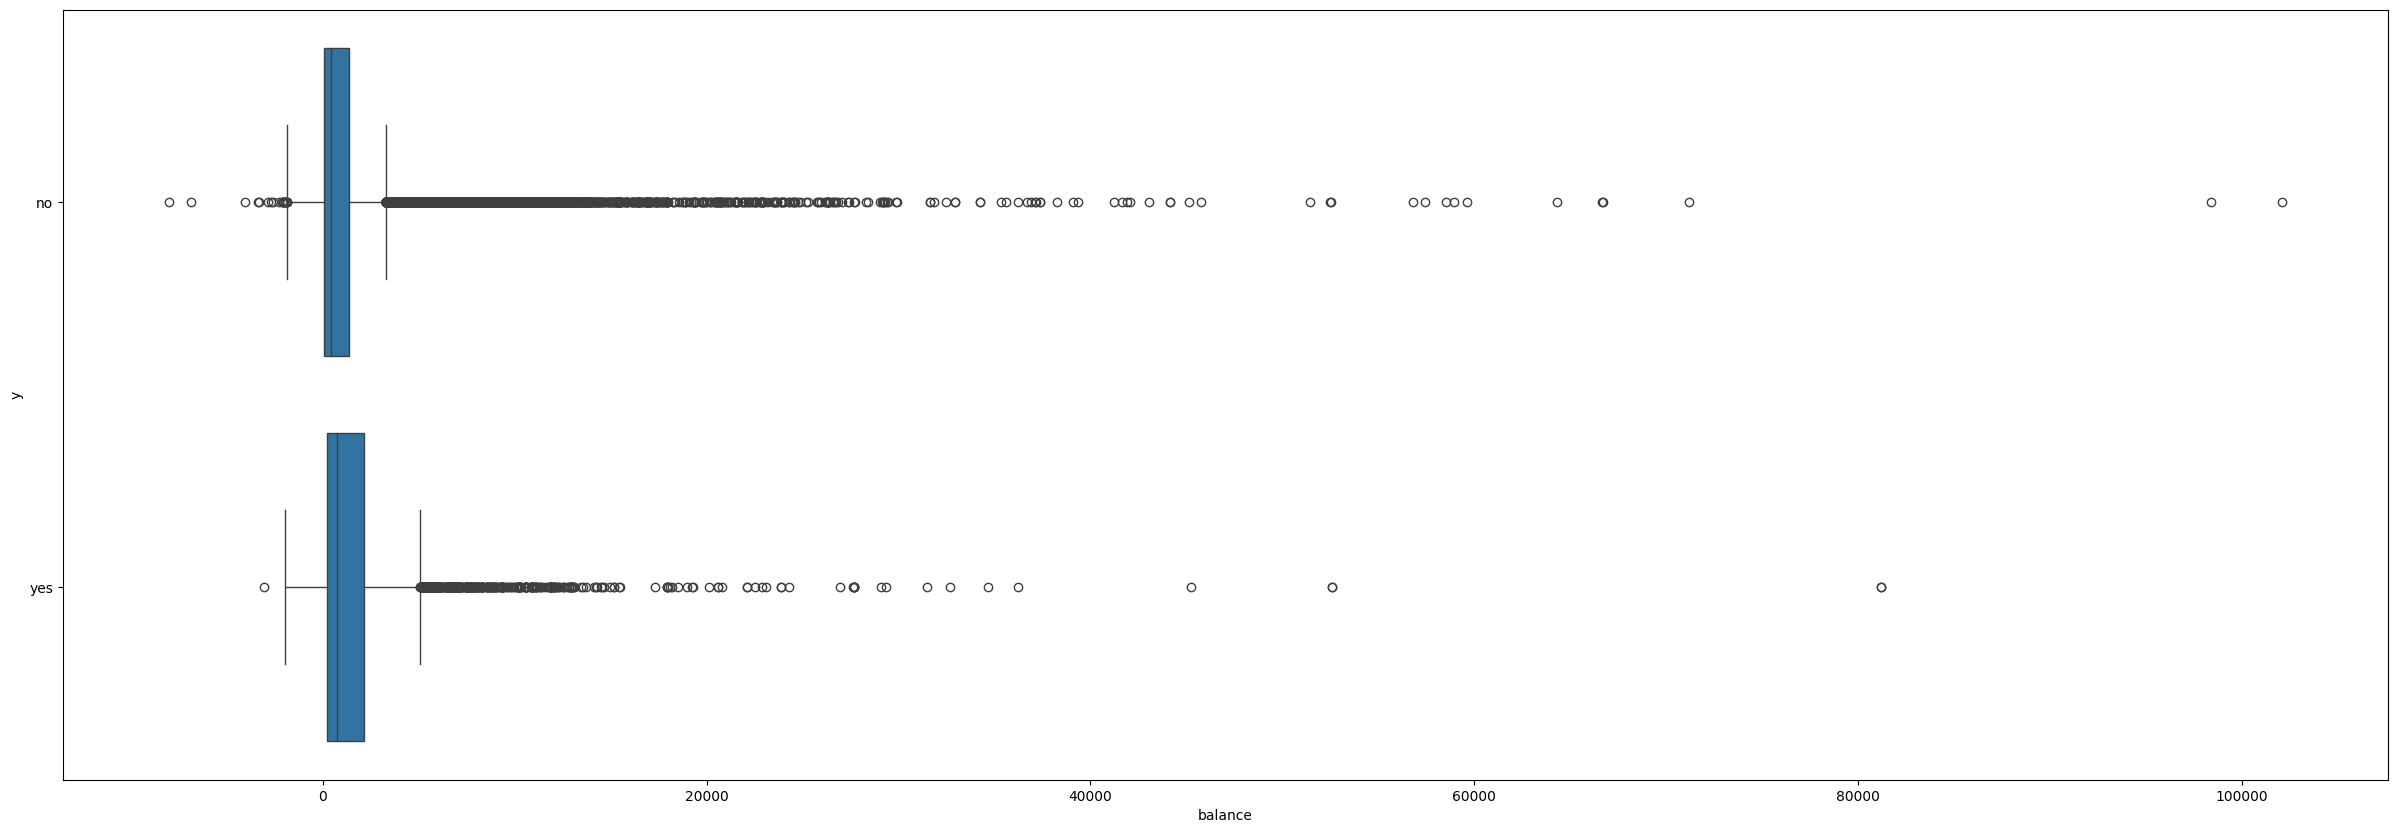

In [27]:
plt.figure(figsize=(30, 10))
sns.boxplot(x=df['balance'], y=df['y']);

Balance is the average annual balance in euros.
There are both positive and negative outliers, which affect the target variable, as shown in the boxplot.
Negative values reflect outstanding balances and are not considered an error.
Outliers represent real customers, so we'll leave them as is.
For scale-insensitive models, we'll leave everything as is; for logistic regression and metric models, we'll apply scaling.

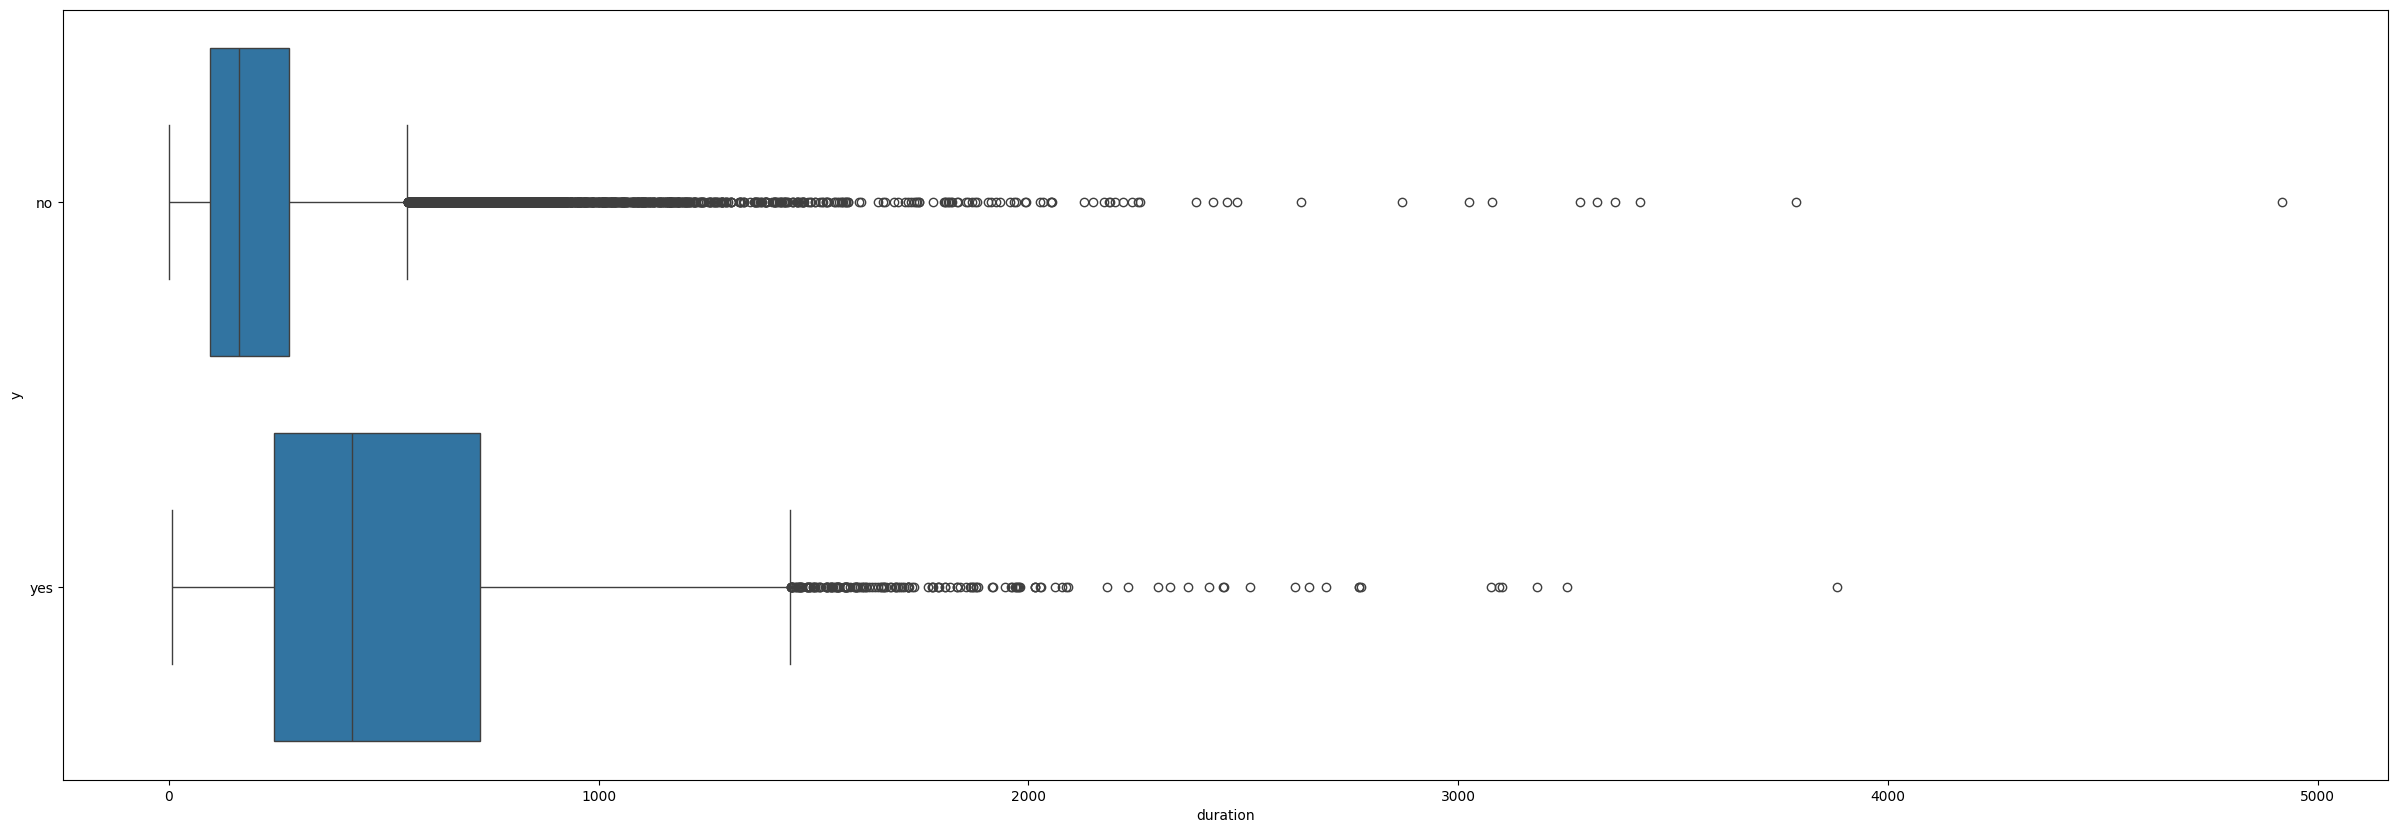

In [35]:
plt.figure(figsize=(30, 10))
sns.boxplot(x=df['duration'], y=df['y']);

Duration - the duration of the last contact in seconds. The longer the conversation, the more likely it is to open a deposit, suggesting the person was initially interested.

,previous,pdays
previous,1.00000,0.45482
pdays,0.45482,1.00000


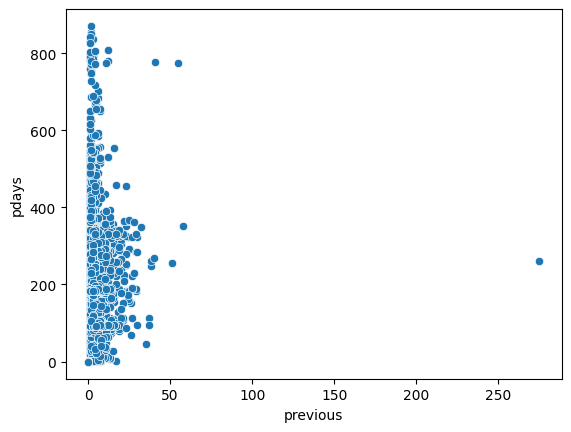

In [94]:
sns.scatterplot(data=df, x='previous', y='pdays');
df[['previous', 'pdays']]. corr()

In [92]:
df.query('pdays == -1 and previous == 0')[['pdays', 'previous']].count() / len(df)

pdays       0.817367
previous    0.817367
dtype: float64

pdays is the number of days since the client's last contact in the previous campaign.
previous is the number of contacts with this client in previous campaigns.
Most clients had no contact (previous = 0, pdays = -1) - 82%, which creates a strong skew in the distributions.
I also assumed a strong correlation between these features; a correlation of 0.45 is average.

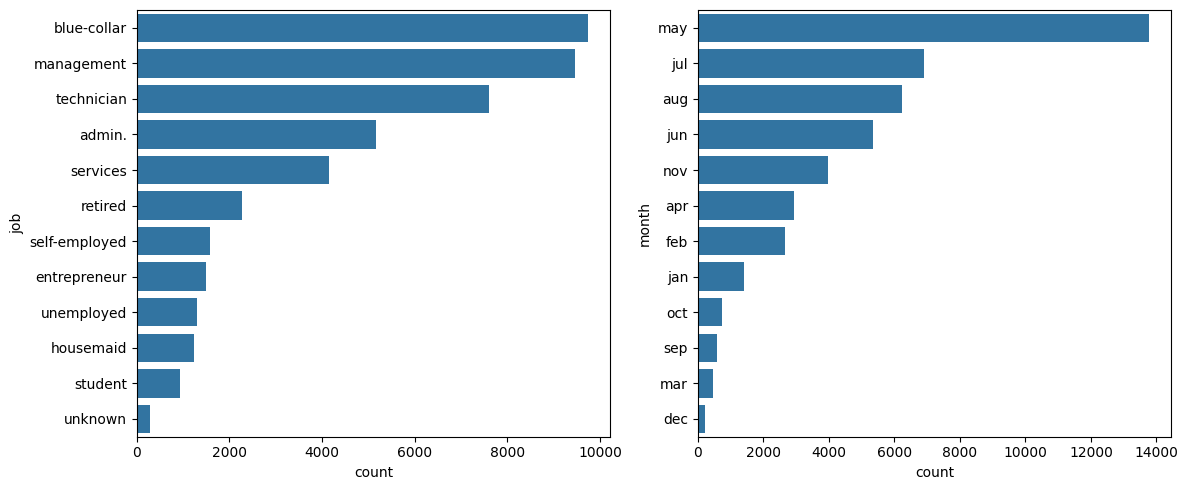

In [98]:
fig, axes =  plt.subplots(1, 2, figsize=(12, 5))
order_j = df['job'].value_counts().index
sns.countplot(df.job, order=order_j, ax=axes[0])
order_m = df['month'].value_counts().index
sns.countplot(df.month, order=order_m, ax=axes[1])
plt.tight_layout();

In [105]:
pd.crosstab(df['job'], df['y'], normalize='index').round(3)

y,no,yes
job,,
admin.,0.878,0.122
blue-collar,0.927,0.073
entrepreneur,0.917,0.083
housemaid,0.912,0.088
management,0.862,0.138
retired,0.772,0.228
self-employed,0.882,0.118
services,0.911,0.089
student,0.713,0.287


The graph shows that the majority of the bank's clients fall into the blue-collar and management categories, while students, housemaids, and the unemployed are significantly less represented.
And according to the cross-table, it is students and the unemployed who are more likely to accept deposits.

In [106]:
pd.crosstab(df['month'], df['y'], normalize='index').round(3)

y,no,yes
month,,
apr,0.803,0.197
aug,0.890,0.110
dec,0.533,0.467
feb,0.834,0.166
jan,0.899,0.101
jul,0.909,0.091
jun,0.898,0.102
mar,0.480,0.520
may,0.933,0.067


Month - last contact with the client.
May, July, and August are the most active months, but the largest number of deposits are made in March, December, and September.

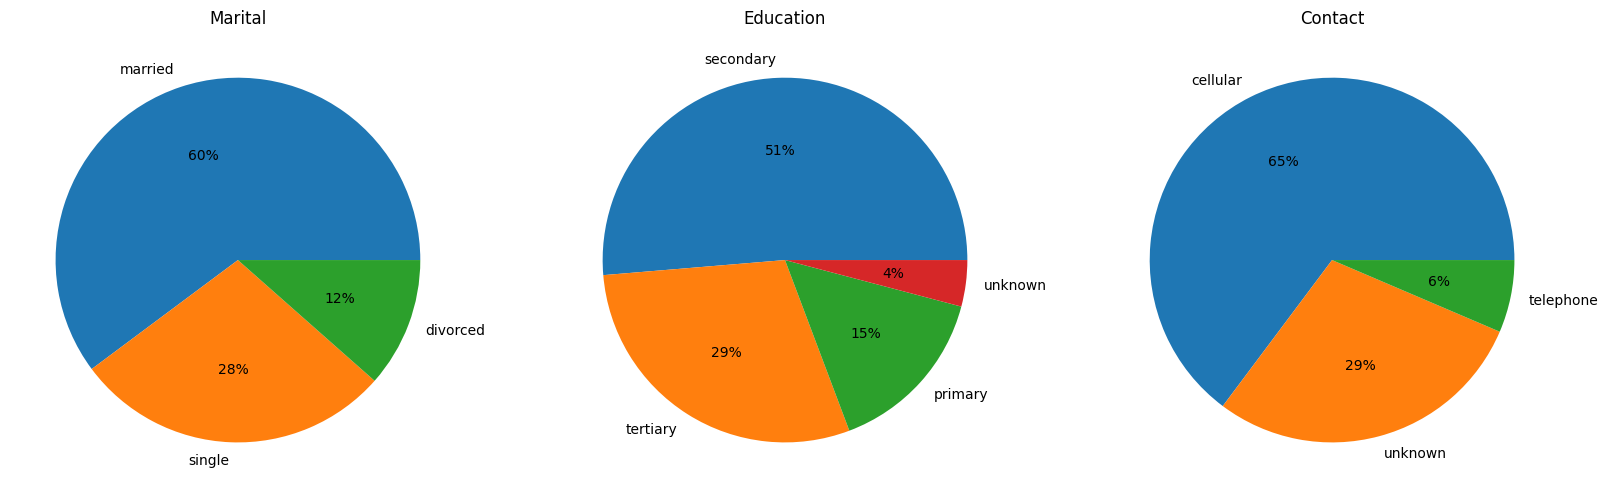

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
df.marital.value_counts().plot(kind='pie', autopct='%1.0f%%', ax=axes[0])
axes[0].set_title('Marital')
axes[0].set_ylabel("")
df.education.value_counts().plot(kind='pie', autopct='%1.0f%%', ax=axes[1])
axes[1].set_title('Education')
axes[1].set_ylabel("")
df.contact.value_counts().plot(kind='pie', autopct='%1.0f%%', ax=axes[2])
axes[2].set_title('Contact')
axes[2].set_ylabel("");

In [119]:
pd.crosstab(df['contact'], df['y'], normalize='index').round(3)

y,no,yes
contact,,
cellular,0.851,0.149
telephone,0.866,0.134
unknown,0.959,0.041


In [121]:
successes = [
    df[(df['contact'] == 'cellular') & (df['y'] == 'yes')].shape[0],
    df[(df['contact'] == 'telephone') & (df['y'] == 'yes')].shape[0]
]
n_obs = [
    df[df['contact'] == 'cellular'].shape[0],
    df[df['contact'] == 'telephone'].shape[0]
]

z_stat, p_val = proportions_ztest(successes, n_obs)
print(f'Z-stat = {z_stat:.2f}, p-value = {p_val:.4f}')

Z-stat = 2.17, p-value = 0.0300


Since "cellular" and "telephone" are close in their meaning and in the cross-tabulation, I considered combining them. To verify, I decided to run a z-test on the two proportions, and I had to accept their 'identity'.
A p-value of 0.03 indicates that the difference between the proportions is statistically significant.

In [123]:
df.default.value_counts(), df.housing.value_counts(), df.loan.value_counts(), df.poutcome.value_counts()

(default
 no     44396
 yes      815
 Name: count, dtype: int64,
 housing
 yes    25130
 no     20081
 Name: count, dtype: int64,
 loan
 no     37967
 yes     7244
 Name: count, dtype: int64,
 poutcome
 unknown    36959
 failure     4901
 other       1840
 success     1511
 Name: count, dtype: int64)

default - whether there is an outstanding loan,
housing - whether there is a mortgage,
loan - whether there is a consumer loan,
poutcome - the result of a previous marketing campaign

In [124]:
num_col_name = df.select_dtypes(include='number').columns.to_list()
cat_col_name = df.select_dtypes(exclude='number').columns.to_list()

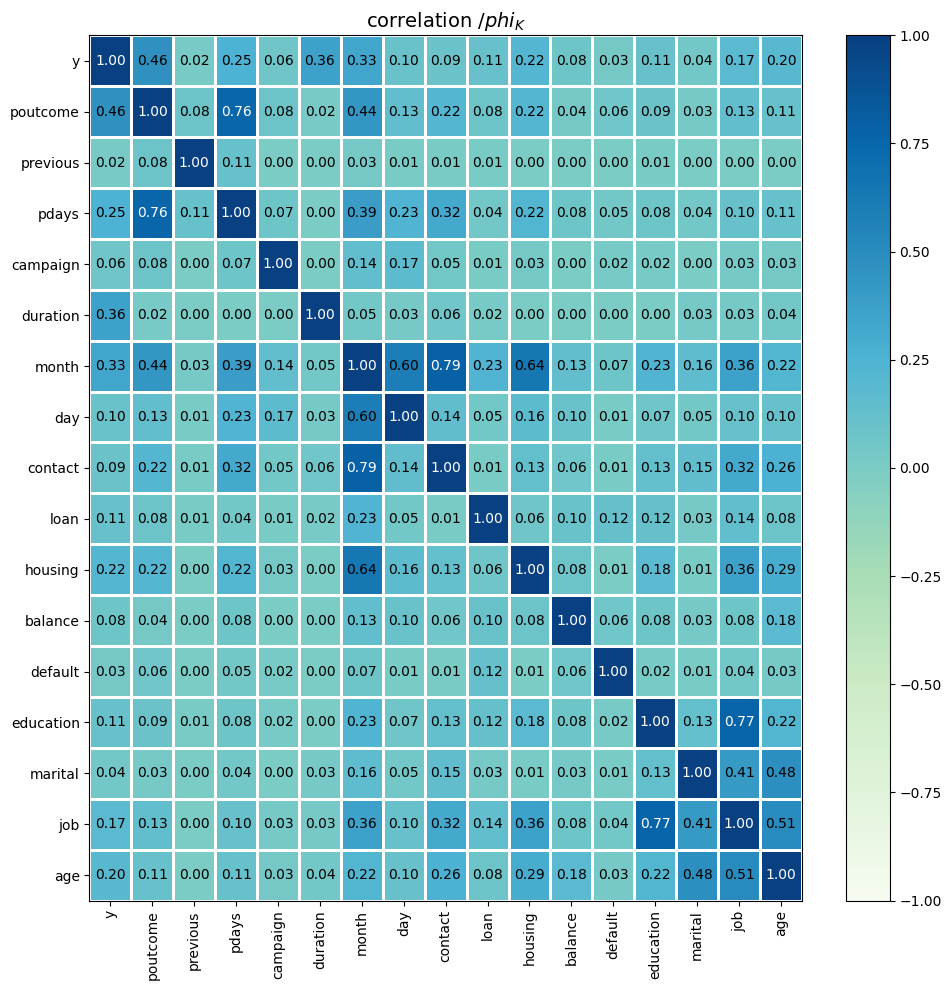

In [142]:
matrix = phik.phik_matrix(df, interval_cols=num_col_name)
plot_correlation_matrix(matrix.values, x_labels=matrix.columns, y_labels=matrix.index,
                       color_map='GnBu', title=r'correlation $/phi_K$', figsize=(10,10))

## Data preparation

In [5]:
df.loc[125]

age                  33
job          technician
marital          single
education     secondary
default              no
balance             105
housing             yes
loan                 no
contact         unknown
day                   5
month               may
duration            262
campaign              2
pdays                -1
previous              0
poutcome        unknown
y                    no
Name: 125, dtype: object

In [3]:
# решила сразу вручную перевести бинарные признаки
binary_cols = ['default', 'housing', 'loan', 'y']
df[binary_cols] = df[binary_cols].apply(lambda col: col.map({'yes':1, 'no':0}))
X = df.drop(columns=['y'])
y = df['y']

In [7]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown


In [8]:
y.value_counts(), 5289/45211

(y
 0    39922
 1     5289
 Name: count, dtype: int64,
 0.11698480458295547)

**Since the data exhibits class imbalance (positive class share is 13%), the primary focus of the model evaluation was on metrics sensitive to imbalance.
I chose PR-AUC (average precision score), which reflects the model's ability to detect rare positive cases and account for the precision/recall ratio.**

**Fix that the random model has a PR-AUC of approximately 0.13**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
y_train.value_counts(), y_test.value_counts()

(y
 0    27945
 1     3702
 Name: count, dtype: int64,
 y
 0    11977
 1     1587
 Name: count, dtype: int64)

In [11]:
X_train.shape, y_train.shape

((31647, 16), (31647,))

In [12]:
X_test.shape, y_test.shape

((13564, 16), (13564,))

In [5]:
cat_cols = X.select_dtypes(exclude='number').columns.to_list()
num_cols = X.select_dtypes(include='number').columns.to_list()
cat_cols, num_cols

(['job', 'marital', 'education', 'contact', 'month', 'poutcome'],
 ['age',
  'default',
  'balance',
  'housing',
  'loan',
  'day',
  'duration',
  'campaign',
  'pdays',
  'previous'])

# Modeling

## Finding the best model

In [19]:
def search_model(X_train, X_test, y_train, y_test, model, param_grid, cat_cols, num_cols):

    pipe = Pipeline([
        ('preprocessor', ColumnTransformer([
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
            ('num', 'passthrough', num_cols),
        ], remainder='drop')), # 'passthrough', если есть другие нужные признаки
         ('model', model)
    ])

    search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='average_precision', random_state=42, n_jobs=-1, verbose=2, n_iter=50)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    predictions = best_model.predict(X_test)
    pr_auc = average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])

    return best_model, pr_auc, predictions

In [7]:
params_tree = {
    'model__max_depth': range(3, 22, 3),
    'model__min_samples_split': range(2, 6),
    'model__min_samples_leaf': range(2,6),
    'preprocessor__cat': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)]
}
model_tree, pr_auc_tree, pred_tree = search_model(X_train, X_test, y_train, y_test, DecisionTreeClassifier(), params_tree, cat_cols, num_cols)
model_tree, pr_auc_tree

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['job', 'marital',
                                                    'education', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', 'passthrough',
                                                   ['age', 'default', 'balance',
                                                    'housing', 'loan', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model',
                  

In [9]:
params_logreg = {
    'model__penalty': ['l2', 'l1'],
    'model__C': [0.1, 0.5, 1, 5, 10],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [1000],
    'preprocessor__num': [StandardScaler(), RobustScaler()]
}
model_logreg, pr_auc_logreg, pred_logreg = search_model(X_train, X_test, y_train, y_test, LogisticRegression(), params_logreg, cat_cols, num_cols)
model_logreg, pr_auc_logreg

C:\projects\jupyter\venv\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits


(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['job', 'marital',
                                                    'education', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', RobustScaler(),
                                                   ['age', 'default', 'balance',
                                                    'housing', 'loan', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model',
                 

In [12]:
params_knn = {
    'model__n_neighbors': range(2, 17, 2),
    'preprocessor__num': [StandardScaler(), RobustScaler()]
}
model_knn, pr_auc_knn, pred_knn = search_model(X_train, X_test, y_train, y_test, KNeighborsClassifier(), params_knn, cat_cols, num_cols)
model_knn, pr_auc_knn

Fitting 5 folds for each of 10 candidates, totalling 50 fits


(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['job', 'marital',
                                                    'education', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', StandardScaler(),
                                                   ['age', 'default', 'balance',
                                                    'housing', 'loan', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model', KNeighborsClass

In [18]:
params_svc = {
    'model__C': [0.1, 1],
    'model__kernel':['rbf'],
    # 'model__gamma': ['scale', 'auto'],
    'model__class_weight': ['balanced'], 
    'preprocessor__num': [StandardScaler()]
}
model_svc, pr_auc_svc, pred_svc = search_model(X_train, X_test, y_train, y_test, SVC(probability=True), params_svc, cat_cols, num_cols)
model_svc, pr_auc_svc

C:\projects\jupyter\venv\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits


(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['job', 'marital',
                                                    'education', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', StandardScaler(),
                                                   ['age', 'default', 'balance',
                                                    'housing', 'loan', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model', SVC(C=1, class_

In [20]:
params_rf = {
    'model__n_estimators': range(30, 101, 10),
    'model__max_depth': range(10, 31, 5),
    'model__min_samples_leaf': range(2, 5),
    'model__min_samples_split': range(2, 20, 5),
    'model__max_features': ['log2', 'sqrt'],
    'preprocessor__cat': [OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)]
}
model_rf, pr_auc_rf, pred_rf = search_model(X_train, X_test, y_train, y_test, RandomForestClassifier(class_weight='balanced', random_state=42), params_rf, cat_cols, num_cols)
model_rf, pr_auc_rf

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['job', 'marital',
                                                    'education', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', 'passthrough',
                                                   ['age', 'default', 'balance',
                                                    'housing', 'loan', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model',
                  

In [22]:
params_xgb = {
    'model__n_estimators': range(100, 801, 50), 
    'model__max_depth': range(2,7),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],# доля обучающей выборки, по умолчанию 1, можно попробовать 0,8 или 0,6 (для борьбы с переобучением)
    'model__colsample_bytree': [0.8, 1.0],# доля признаков для обучения каждого дерева, по умолчанию 1, можно попробовать 0,8 или 0,6 для разнообразия деревьев
    'model__gamma': [0, 0.1, 0.5], #минимальное уменьшение функции потерь, 0 - без ограничений, 1 - сильно ограничивает (деревья могут недообучиться)
    'model__reg_alpha': [0, 0.01, 0.1, 1],# L1-регуляризация
    'model__reg_lambda': [0.1, 1, 10],# L2-регуляризация
    'model__scale_pos_weight': [1, 3, 5, 7],# балансировка классов (увеличивает вес ошибок редкого класса), 1 - без балансировки ...
    'preprocessor__num': ['passthrough', RobustScaler(), StandardScaler()]
}
model_xgb, pr_auc_xgb, pred_xgb = search_model(X_train, X_test, y_train, y_test, XGBClassifier(random_state=42), params_xgb, cat_cols, num_cols)
model_xgb, pr_auc_xgb

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['job', 'marital',
                                                    'education', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', StandardScaler(),
                                                   ['age', 'default', 'balance',
                                                    'housing', 'loan', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model',
               

In [25]:
params_lgb = {
    'model__n_estimators': range(100, 801, 50), 
    'model__max_depth': range(2,7),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__min_split_gain': [0, 0.1, 0.5],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 10],
    'model__scale_pos_weight': [1, 3, 5, 7],
    'preprocessor__num': ['passthrough', RobustScaler(), StandardScaler()]
}
model_lgb, pr_auc_lgb, pred_lgb = search_model(X_train, X_test, y_train, y_test, LGBMClassifier(random_state=42), params_lgb, cat_cols, num_cols)
model_lgb, pr_auc_lgb

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 3702, number of negative: 27945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 31647, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116978 -> initscore=-2.021365
[LightGBM] [Info] Start training from score -2.021365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore',
                                                                 sparse_output=False),
                                                   ['job', 'marital',
                                                    'education', 'contact',
                                                    'month', 'poutcome']),
                                                  ('num', RobustScaler(),
                                                   ['age', 'default', 'balance',
                                                    'housing', 'loan', 'day',
                                                    'duration', 'campaign',
                                                    'pdays', 'previous'])])),
                 ('model',
                 

In [ ]:
# предупреждения возникают, потому что мы обучаем через ColumnTransformer и OneHotEncoder преобразует данные и подаёт на обучение, 
# а потом на предикт мы подаём не преобразованные данные, в целом LightGBM контролирует этот процесс, но выкидывает предупреждения

In [30]:
params_catb = {
    'iterations': range(100, 801, 50),
    'depth': range(2, 7),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bylevel': [0.8, 1.0],
    'l2_leaf_reg': [1, 3, 5, 10],
    'scale_pos_weight': [1, 3, 5, 7]
}
search = RandomizedSearchCV(CatBoostClassifier(cat_features=cat_cols, random_state=42, verbose=0), params_catb, cv=5, scoring='average_precision', random_state=42, n_jobs=-1, verbose=2, n_iter=50)
search.fit(X_train, y_train)

model_catb = search.best_estimator_
pr_auc_catb = average_precision_score(y_test, search.best_estimator_.predict_proba(X_test)[:, 1])
model_catb, pr_auc_catb

Fitting 5 folds for each of 50 candidates, totalling 250 fits


(<catboost.core.CatBoostClassifier at 0x1e913304400>, 0.6338540205398377)

In [31]:
search.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 7,
 'learning_rate': 0.05,
 'l2_leaf_reg': 3,
 'iterations': 800,
 'depth': 6,
 'colsample_bylevel': 1.0}

In [ ]:
# обычный Target Encoding вычисляет среднее по каждой категории (небезопасно(утечка)),
# а Ordered Target Encoding в CatBoost идёт по строкам в порядке их появления (или в случайно перемешанном), и для каждой строки кодирует категорию, используя только предыдущие строки.

## Comparison of boosting models

The XGBoost, LightGBM, and CatBoost metrics are approximately 0.622, 0.617, and 0.634, respectively; the difference is inconclusive.

Run cross-validation for three models with the same data and compare the mean and standard deviation of each model's metric.

In [32]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=25)
scores_lgbm = cross_val_score(model_lgb, X_train, y_train, scoring='average_precision', cv=cv)
scores_xgb  = cross_val_score(model_xgb,  X_train, y_train, scoring='average_precision', cv=cv)
scores_catb = cross_val_score(model_catb, X_train, y_train, scoring='average_precision', cv=cv)

print('LGBM avg:', scores_lgbm.mean(), '+-', scores_lgbm.std())
print('XGB  avg:', scores_xgb.mean(), '+-', scores_xgb.std())
print('CatBoost avg:', scores_catb.mean(), '+-', scores_catb.std())

[LightGBM] [Info] Number of positive: 2961, number of negative: 22356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 25317, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116957 -> initscore=-2.021568
[LightGBM] [Info] Start training from score -2.021568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2961, number of negative: 22356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 25317, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116957 -> initscore=-2.021568
[LightGBM] [Info] Start training from score -2.021568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBM avg: 0.624 +- 0.015

XGB  avg: 0.624 +- 0.01

CatBoost avg: 0.63 +- 0.01

A difference of less than one standard deviation can be considered statistically insignificant.

C:\projects\jupyter\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


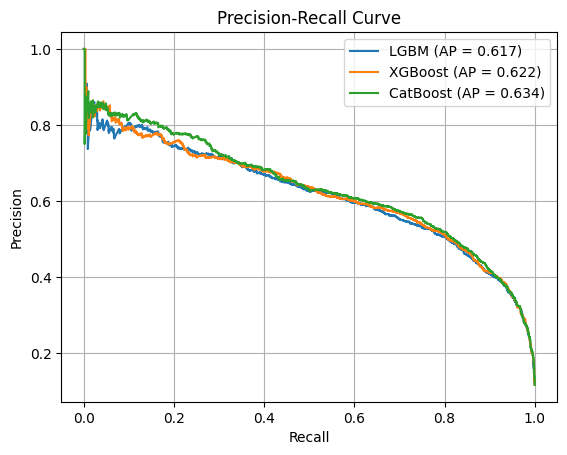

In [33]:
def pr_curve(y_true, y_scores, name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AP = {ap:.3f})')

pr_curve(y_test, model_lgb.predict_proba(X_test)[:, 1], 'LGBM')
pr_curve(y_test, model_xgb.predict_proba(X_test)[:, 1], 'XGBoost')
pr_curve(y_test, model_catb.predict_proba(X_test)[:, 1], 'CatBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.grid()

The PR curves are almost identical.

I'll choose the CatBoost model for further work because:
* it's more stable due to its symmetrical trees
* it's easier to interpret features
* it's slower, but since the dataset is small, the difference won't be very noticeable.

## MLP(multilayer perceptron)

Of course, for tabular data and such a small number of observations, a neural network isn't the best choice, but it's interesting to test this in practice. I'll build a small, fully connected model.

In [85]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', RobustScaler(), num_cols),
], remainder='drop')

X_train_mlp = preprocessor.fit_transform(X_train)
X_test_mlp = preprocessor.transform(X_test)

In [86]:
X_train_tensor = torch.tensor(X_train_mlp, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_mlp, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

train = TensorDataset(X_train_tensor, y_train_tensor)
test = TensorDataset(X_test_tensor, y_test_tensor)

In [87]:
train[5]

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
         -0.4667,  0.0000, -0.3009, -1.0000,  0.0000,  0.4615, -0.1168,  1.5000,
          0.0000,  0.0000]),
 tensor([0.]))

In [88]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.7.1+cu118
11.8
True


In [89]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [94]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)


model = MLP(input_dim=X_train_tensor.shape[1])

In [95]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [96]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

In [97]:
model = model.to(device)

for epoch in range(200):
    model.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_func(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        preds = model(X_test_tensor)
        test_loss = loss_func(preds, y_test_tensor)
    print(f"Epoch {epoch+1}/200, Train loss: {train_loss/len(train_loader):.4f}, Test loss: {test_loss:.4f}")

100%|███████████████████████████████████████| 495/495 [00:01<00:00, 300.19it/s]


Epoch 1/200, Train loss: 0.3006, Test loss: 0.2345


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 452.60it/s]


Epoch 2/200, Train loss: 0.2476, Test loss: 0.2317


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 439.22it/s]


Epoch 3/200, Train loss: 0.2415, Test loss: 0.2246


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 409.42it/s]


Epoch 4/200, Train loss: 0.2392, Test loss: 0.2301


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 407.53it/s]


Epoch 5/200, Train loss: 0.2323, Test loss: 0.2312


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 331.99it/s]


Epoch 6/200, Train loss: 0.2358, Test loss: 0.2313


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 468.30it/s]


Epoch 7/200, Train loss: 0.2310, Test loss: 0.2212


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 460.84it/s]


Epoch 8/200, Train loss: 0.2292, Test loss: 0.2334


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 473.42it/s]


Epoch 9/200, Train loss: 0.2316, Test loss: 0.2190


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 481.98it/s]


Epoch 10/200, Train loss: 0.2295, Test loss: 0.2423


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 487.16it/s]


Epoch 11/200, Train loss: 0.2292, Test loss: 0.2176


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 483.87it/s]


Epoch 12/200, Train loss: 0.2280, Test loss: 0.2167


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 466.96it/s]


Epoch 13/200, Train loss: 0.2254, Test loss: 0.2159


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.02it/s]


Epoch 14/200, Train loss: 0.2253, Test loss: 0.2200


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.99it/s]


Epoch 15/200, Train loss: 0.2266, Test loss: 0.2169


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 490.08it/s]


Epoch 16/200, Train loss: 0.2261, Test loss: 0.2191


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.01it/s]


Epoch 17/200, Train loss: 0.2230, Test loss: 0.2174


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 494.03it/s]


Epoch 18/200, Train loss: 0.2234, Test loss: 0.2133


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.00it/s]


Epoch 19/200, Train loss: 0.2237, Test loss: 0.2175


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 485.79it/s]


Epoch 20/200, Train loss: 0.2233, Test loss: 0.2177


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.76it/s]


Epoch 21/200, Train loss: 0.2217, Test loss: 0.2188


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 495.00it/s]


Epoch 22/200, Train loss: 0.2221, Test loss: 0.2173


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.99it/s]


Epoch 23/200, Train loss: 0.2232, Test loss: 0.2142


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.06it/s]


Epoch 24/200, Train loss: 0.2200, Test loss: 0.2192


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.99it/s]


Epoch 25/200, Train loss: 0.2241, Test loss: 0.2129


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 491.31it/s]


Epoch 26/200, Train loss: 0.2226, Test loss: 0.2123


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.49it/s]


Epoch 27/200, Train loss: 0.2221, Test loss: 0.2150


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.49it/s]


Epoch 28/200, Train loss: 0.2203, Test loss: 0.2118


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.99it/s]


Epoch 29/200, Train loss: 0.2186, Test loss: 0.2123


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.73it/s]


Epoch 30/200, Train loss: 0.2176, Test loss: 0.2148


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 496.94it/s]


Epoch 31/200, Train loss: 0.2200, Test loss: 0.2102


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 494.22it/s]


Epoch 32/200, Train loss: 0.2213, Test loss: 0.2161


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.99it/s]


Epoch 33/200, Train loss: 0.2228, Test loss: 0.2145


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.44it/s]


Epoch 34/200, Train loss: 0.2213, Test loss: 0.2264


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.49it/s]


Epoch 35/200, Train loss: 0.2194, Test loss: 0.2120


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 484.35it/s]


Epoch 36/200, Train loss: 0.2192, Test loss: 0.2126


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.49it/s]


Epoch 37/200, Train loss: 0.2167, Test loss: 0.2112


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.99it/s]


Epoch 38/200, Train loss: 0.2185, Test loss: 0.2130


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.23it/s]


Epoch 39/200, Train loss: 0.2217, Test loss: 0.2119


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.99it/s]


Epoch 40/200, Train loss: 0.2208, Test loss: 0.2220


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.94it/s]


Epoch 41/200, Train loss: 0.2189, Test loss: 0.2130


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 494.33it/s]


Epoch 42/200, Train loss: 0.2189, Test loss: 0.2162


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 497.49it/s]


Epoch 43/200, Train loss: 0.2195, Test loss: 0.2115


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 496.41it/s]


Epoch 44/200, Train loss: 0.2169, Test loss: 0.2088


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 499.50it/s]


Epoch 45/200, Train loss: 0.2204, Test loss: 0.2119


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 492.54it/s]


Epoch 46/200, Train loss: 0.2178, Test loss: 0.2077


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 493.28it/s]


Epoch 47/200, Train loss: 0.2169, Test loss: 0.2116


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 493.03it/s]


Epoch 48/200, Train loss: 0.2151, Test loss: 0.2114


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.99it/s]


Epoch 49/200, Train loss: 0.2172, Test loss: 0.2113


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 498.49it/s]


Epoch 50/200, Train loss: 0.2180, Test loss: 0.2088


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 490.59it/s]


Epoch 51/200, Train loss: 0.2191, Test loss: 0.2113


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 420.20it/s]


Epoch 52/200, Train loss: 0.2169, Test loss: 0.2212


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 419.85it/s]


Epoch 53/200, Train loss: 0.2177, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 398.87it/s]


Epoch 54/200, Train loss: 0.2167, Test loss: 0.2157


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.41it/s]


Epoch 55/200, Train loss: 0.2182, Test loss: 0.2089


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.73it/s]


Epoch 56/200, Train loss: 0.2167, Test loss: 0.2121


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.77it/s]


Epoch 57/200, Train loss: 0.2163, Test loss: 0.2083


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.55it/s]


Epoch 58/200, Train loss: 0.2157, Test loss: 0.2103


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 395.05it/s]


Epoch 59/200, Train loss: 0.2162, Test loss: 0.2081


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.42it/s]


Epoch 60/200, Train loss: 0.2170, Test loss: 0.2080


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.04it/s]


Epoch 61/200, Train loss: 0.2171, Test loss: 0.2224


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.32it/s]


Epoch 62/200, Train loss: 0.2192, Test loss: 0.2123


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 378.62it/s]


Epoch 63/200, Train loss: 0.2167, Test loss: 0.2107


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.61it/s]


Epoch 64/200, Train loss: 0.2186, Test loss: 0.2110


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.53it/s]


Epoch 65/200, Train loss: 0.2185, Test loss: 0.2093


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.25it/s]


Epoch 66/200, Train loss: 0.2170, Test loss: 0.2145


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 395.36it/s]


Epoch 67/200, Train loss: 0.2171, Test loss: 0.2110


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.54it/s]


Epoch 68/200, Train loss: 0.2182, Test loss: 0.2063


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.87it/s]


Epoch 69/200, Train loss: 0.2177, Test loss: 0.2069


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.56it/s]


Epoch 70/200, Train loss: 0.2166, Test loss: 0.2101


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.96it/s]


Epoch 71/200, Train loss: 0.2156, Test loss: 0.2076


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.48it/s]


Epoch 72/200, Train loss: 0.2153, Test loss: 0.2081


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.47it/s]


Epoch 73/200, Train loss: 0.2168, Test loss: 0.2110


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.48it/s]


Epoch 74/200, Train loss: 0.2168, Test loss: 0.2080


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.11it/s]


Epoch 75/200, Train loss: 0.2161, Test loss: 0.2099


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.42it/s]


Epoch 76/200, Train loss: 0.2162, Test loss: 0.2064


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 405.54it/s]


Epoch 77/200, Train loss: 0.2177, Test loss: 0.2081


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 409.44it/s]


Epoch 78/200, Train loss: 0.2153, Test loss: 0.2090


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 409.26it/s]


Epoch 79/200, Train loss: 0.2152, Test loss: 0.2084


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 407.41it/s]


Epoch 80/200, Train loss: 0.2183, Test loss: 0.2094


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 407.42it/s]


Epoch 81/200, Train loss: 0.2157, Test loss: 0.2093


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 407.39it/s]


Epoch 82/200, Train loss: 0.2151, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 406.39it/s]


Epoch 83/200, Train loss: 0.2132, Test loss: 0.2088


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 406.39it/s]


Epoch 84/200, Train loss: 0.2164, Test loss: 0.2093


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 407.07it/s]


Epoch 85/200, Train loss: 0.2156, Test loss: 0.2170


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 405.07it/s]


Epoch 86/200, Train loss: 0.2155, Test loss: 0.2095


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 405.06it/s]


Epoch 87/200, Train loss: 0.2155, Test loss: 0.2087


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 406.06it/s]


Epoch 88/200, Train loss: 0.2154, Test loss: 0.2090


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 406.39it/s]


Epoch 89/200, Train loss: 0.2160, Test loss: 0.2080


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 398.87it/s]


Epoch 90/200, Train loss: 0.2158, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.43it/s]


Epoch 91/200, Train loss: 0.2163, Test loss: 0.2102


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.42it/s]


Epoch 92/200, Train loss: 0.2171, Test loss: 0.2080


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 395.68it/s]


Epoch 93/200, Train loss: 0.2155, Test loss: 0.2090


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.79it/s]


Epoch 94/200, Train loss: 0.2161, Test loss: 0.2128


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.84it/s]


Epoch 95/200, Train loss: 0.2149, Test loss: 0.2049


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.41it/s]


Epoch 96/200, Train loss: 0.2152, Test loss: 0.2114


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.85it/s]


Epoch 97/200, Train loss: 0.2146, Test loss: 0.2070


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.33it/s]


Epoch 98/200, Train loss: 0.2156, Test loss: 0.2073


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.79it/s]


Epoch 99/200, Train loss: 0.2170, Test loss: 0.2148


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.54it/s]


Epoch 100/200, Train loss: 0.2165, Test loss: 0.2085


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 396.64it/s]


Epoch 101/200, Train loss: 0.2170, Test loss: 0.2069


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.45it/s]


Epoch 102/200, Train loss: 0.2187, Test loss: 0.2067


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.49it/s]


Epoch 103/200, Train loss: 0.2156, Test loss: 0.2077


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.73it/s]


Epoch 104/200, Train loss: 0.2140, Test loss: 0.2056


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.61it/s]


Epoch 105/200, Train loss: 0.2143, Test loss: 0.2064


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.35it/s]


Epoch 106/200, Train loss: 0.2147, Test loss: 0.2072


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 395.05it/s]


Epoch 107/200, Train loss: 0.2148, Test loss: 0.2134


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.66it/s]


Epoch 108/200, Train loss: 0.2141, Test loss: 0.2077


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.22it/s]


Epoch 109/200, Train loss: 0.2170, Test loss: 0.2059


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 396.32it/s]


Epoch 110/200, Train loss: 0.2130, Test loss: 0.2098


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 452.88it/s]


Epoch 111/200, Train loss: 0.2175, Test loss: 0.2076


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 493.51it/s]


Epoch 112/200, Train loss: 0.2162, Test loss: 0.2077


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 487.20it/s]


Epoch 113/200, Train loss: 0.2143, Test loss: 0.2090


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 491.06it/s]


Epoch 114/200, Train loss: 0.2147, Test loss: 0.2087


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 494.02it/s]


Epoch 115/200, Train loss: 0.2146, Test loss: 0.2084


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.98it/s]


Epoch 116/200, Train loss: 0.2142, Test loss: 0.2084


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.00it/s]


Epoch 117/200, Train loss: 0.2145, Test loss: 0.2076


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.98it/s]


Epoch 118/200, Train loss: 0.2128, Test loss: 0.2106


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.47it/s]


Epoch 119/200, Train loss: 0.2144, Test loss: 0.2064


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.49it/s]


Epoch 120/200, Train loss: 0.2171, Test loss: 0.2071


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 491.56it/s]


Epoch 121/200, Train loss: 0.2153, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 495.48it/s]


Epoch 122/200, Train loss: 0.2135, Test loss: 0.2081


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 489.11it/s]


Epoch 123/200, Train loss: 0.2129, Test loss: 0.2065


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 492.07it/s]


Epoch 124/200, Train loss: 0.2143, Test loss: 0.2080


100%|███████████████████████████████████████| 495/495 [00:00<00:00, 496.97it/s]


Epoch 125/200, Train loss: 0.2127, Test loss: 0.2069


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 493.99it/s]


Epoch 126/200, Train loss: 0.2124, Test loss: 0.2059


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 494.00it/s]


Epoch 127/200, Train loss: 0.2143, Test loss: 0.2085


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 494.49it/s]


Epoch 128/200, Train loss: 0.2121, Test loss: 0.2055


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 467.07it/s]


Epoch 129/200, Train loss: 0.2143, Test loss: 0.2125


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 417.43it/s]


Epoch 130/200, Train loss: 0.2163, Test loss: 0.2090


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 415.62it/s]


Epoch 131/200, Train loss: 0.2134, Test loss: 0.2062


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.76it/s]


Epoch 132/200, Train loss: 0.2155, Test loss: 0.2075


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.14it/s]


Epoch 133/200, Train loss: 0.2152, Test loss: 0.2072


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 390.26it/s]


Epoch 134/200, Train loss: 0.2145, Test loss: 0.2073


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 376.71it/s]


Epoch 135/200, Train loss: 0.2130, Test loss: 0.2075


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.24it/s]


Epoch 136/200, Train loss: 0.2130, Test loss: 0.2054


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.62it/s]


Epoch 137/200, Train loss: 0.2146, Test loss: 0.2109


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.84it/s]


Epoch 138/200, Train loss: 0.2142, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 387.92it/s]


Epoch 139/200, Train loss: 0.2126, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 386.19it/s]


Epoch 140/200, Train loss: 0.2150, Test loss: 0.2094


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.37it/s]


Epoch 141/200, Train loss: 0.2163, Test loss: 0.2093


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.45it/s]


Epoch 142/200, Train loss: 0.2138, Test loss: 0.2054


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.51it/s]


Epoch 143/200, Train loss: 0.2142, Test loss: 0.2073


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.14it/s]


Epoch 144/200, Train loss: 0.2111, Test loss: 0.2133


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.75it/s]


Epoch 145/200, Train loss: 0.2133, Test loss: 0.2071


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 387.02it/s]


Epoch 146/200, Train loss: 0.2127, Test loss: 0.2079


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.20it/s]


Epoch 147/200, Train loss: 0.2137, Test loss: 0.2047


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.76it/s]


Epoch 148/200, Train loss: 0.2095, Test loss: 0.2057


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 390.06it/s]


Epoch 149/200, Train loss: 0.2124, Test loss: 0.2087


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.22it/s]


Epoch 150/200, Train loss: 0.2154, Test loss: 0.2077


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 387.02it/s]


Epoch 151/200, Train loss: 0.2132, Test loss: 0.2116


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.23it/s]


Epoch 152/200, Train loss: 0.2163, Test loss: 0.2052


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 386.42it/s]


Epoch 153/200, Train loss: 0.2138, Test loss: 0.2062


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 384.02it/s]


Epoch 154/200, Train loss: 0.2128, Test loss: 0.2077


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.75it/s]


Epoch 155/200, Train loss: 0.2134, Test loss: 0.2092


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.22it/s]


Epoch 156/200, Train loss: 0.2118, Test loss: 0.2070


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 390.57it/s]


Epoch 157/200, Train loss: 0.2114, Test loss: 0.2110


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.29it/s]


Epoch 158/200, Train loss: 0.2105, Test loss: 0.2058


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.47it/s]


Epoch 159/200, Train loss: 0.2143, Test loss: 0.2038


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.86it/s]


Epoch 160/200, Train loss: 0.2126, Test loss: 0.2092


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.97it/s]


Epoch 161/200, Train loss: 0.2121, Test loss: 0.2057


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.14it/s]


Epoch 162/200, Train loss: 0.2133, Test loss: 0.2076


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.16it/s]


Epoch 163/200, Train loss: 0.2155, Test loss: 0.2072


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.31it/s]


Epoch 164/200, Train loss: 0.2100, Test loss: 0.2051


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.10it/s]


Epoch 165/200, Train loss: 0.2136, Test loss: 0.2132


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.53it/s]


Epoch 166/200, Train loss: 0.2121, Test loss: 0.2047


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.99it/s]


Epoch 167/200, Train loss: 0.2094, Test loss: 0.2074


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.16it/s]


Epoch 168/200, Train loss: 0.2115, Test loss: 0.2096


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.53it/s]


Epoch 169/200, Train loss: 0.2131, Test loss: 0.2091


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 402.12it/s]


Epoch 170/200, Train loss: 0.2135, Test loss: 0.2079


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 404.23it/s]


Epoch 171/200, Train loss: 0.2139, Test loss: 0.2154


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.15it/s]


Epoch 172/200, Train loss: 0.2125, Test loss: 0.2082


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 395.04it/s]


Epoch 173/200, Train loss: 0.2129, Test loss: 0.2071


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.17it/s]


Epoch 174/200, Train loss: 0.2132, Test loss: 0.2116


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.11it/s]


Epoch 175/200, Train loss: 0.2122, Test loss: 0.2085


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.85it/s]


Epoch 176/200, Train loss: 0.2118, Test loss: 0.2075


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.48it/s]


Epoch 177/200, Train loss: 0.2106, Test loss: 0.2067


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.91it/s]


Epoch 178/200, Train loss: 0.2117, Test loss: 0.2081


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.92it/s]


Epoch 179/200, Train loss: 0.2122, Test loss: 0.2079


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.21it/s]


Epoch 180/200, Train loss: 0.2139, Test loss: 0.2089


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.50it/s]


Epoch 181/200, Train loss: 0.2119, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 388.84it/s]


Epoch 182/200, Train loss: 0.2116, Test loss: 0.2082


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 389.85it/s]


Epoch 183/200, Train loss: 0.2127, Test loss: 0.2104


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 390.75it/s]


Epoch 184/200, Train loss: 0.2131, Test loss: 0.2054


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.86it/s]


Epoch 185/200, Train loss: 0.2141, Test loss: 0.2056


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 394.41it/s]


Epoch 186/200, Train loss: 0.2125, Test loss: 0.2073


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.17it/s]


Epoch 187/200, Train loss: 0.2117, Test loss: 0.2148


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 395.04it/s]


Epoch 188/200, Train loss: 0.2121, Test loss: 0.2048


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.89it/s]


Epoch 189/200, Train loss: 0.2117, Test loss: 0.2111


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.92it/s]


Epoch 190/200, Train loss: 0.2152, Test loss: 0.2063


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 390.61it/s]


Epoch 191/200, Train loss: 0.2126, Test loss: 0.2071


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.16it/s]


Epoch 192/200, Train loss: 0.2141, Test loss: 0.2090


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.41it/s]


Epoch 193/200, Train loss: 0.2122, Test loss: 0.2060


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 391.92it/s]


Epoch 194/200, Train loss: 0.2142, Test loss: 0.2082


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 390.42it/s]


Epoch 195/200, Train loss: 0.2113, Test loss: 0.2045


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.33it/s]


Epoch 196/200, Train loss: 0.2144, Test loss: 0.2069


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.54it/s]


Epoch 197/200, Train loss: 0.2180, Test loss: 0.2079


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 390.99it/s]


Epoch 198/200, Train loss: 0.2150, Test loss: 0.2110


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 393.79it/s]


Epoch 199/200, Train loss: 0.2147, Test loss: 0.2086


100%|███████████████████████████████████████| 495/495 [00:01<00:00, 392.95it/s]

Epoch 200/200, Train loss: 0.2138, Test loss: 0.2116


In [99]:
y_proba = model(X_test_tensor.to(device)).cpu().detach().numpy()
average_precision_score(y_test_tensor.cpu().numpy(), y_proba)

0.5833304195288462

Despite its simplicity and small data set, the model performed well (pr-auc=0.58). However, since the neural network operates as a 'black box' and we cannot interpret its choices, we will abandon this experiment and return to boosting.

##  Interpretation and optimization

Perform a more "narrow" tuning using GridSearchCV; it may be possible to select more successful combinations of hyperparameters.

In [6]:
params_catb = {
    'iterations': [700, 800, 900],
    'depth': [5, 6],
    'learning_rate': [0.05, 0.07],
    # 'subsample': [0.7, 0.8, 0.9, 1],
    # 'colsample_bylevel': [0.7, 0.8, 0.9, 1],
    'l2_leaf_reg': [3, 5, 10],
    # 'scale_pos_weight': [4, 5, 6]
}
search = GridSearchCV(CatBoostClassifier(cat_features=cat_cols, subsample=0.8, scale_pos_weight=7, random_state=42, verbose=0), params_catb, cv=5, scoring='average_precision', n_jobs=-1, verbose=2)
search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,<catboost.cor...001D06E264490>
,param_grid,"{'depth': [5, 6], 'iterations': [700, 800, ...], 'l2_leaf_reg': [3, 5, ...], 'learning_rate': [0.05, 0.07]}"
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [7]:
search.best_params_, search.best_score_, average_precision_score(y_test, search.best_estimator_.predict_proba(X_test)[:, 1])

({'depth': 6, 'iterations': 700, 'l2_leaf_reg': 10, 'learning_rate': 0.05},
 np.float64(0.638422459872013),
 0.6301754665870563)

Conduct an experiment varying the tree depth and the number of iterations, which will allow us to visually assess the dependence of the quality metric on the model complexity.
This will help us choose the optimal combination that minimizes the overall error (bias + variance).

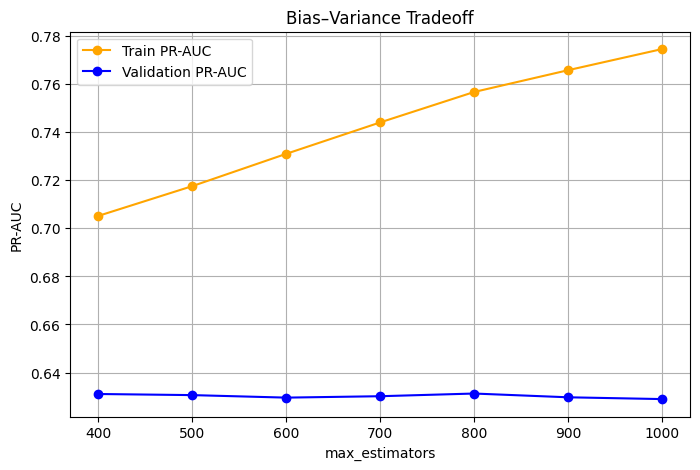

In [9]:
estimator_values = [400, 500, 600, 700, 800, 900, 1000]

train_scores = []
test_scores = []

for estimator in estimator_values:
    model = CatBoostClassifier(cat_features=cat_cols, iterations=estimator, depth=6, l2_leaf_reg=10, learning_rate=0.05, subsample=0.8, scale_pos_weight=7, random_state=42, verbose=0)
    model.fit(X_train, y_train, cat_features=cat_cols, verbose=0)

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]

    train_scores.append(average_precision_score(y_train, y_train_pred))
    test_scores.append(average_precision_score(y_test, y_test_pred))

plt.figure(figsize=(8, 5))
plt.plot(estimator_values, train_scores, marker='o', label='Train PR-AUC', color='orange')
plt.plot(estimator_values, test_scores, marker='o', label='Validation PR-AUC', color='blue')
plt.xlabel('max_estimators')
plt.ylabel('PR-AUC')
plt.title('Bias–Variance Tradeoff')
plt.legend()
plt.grid(True)

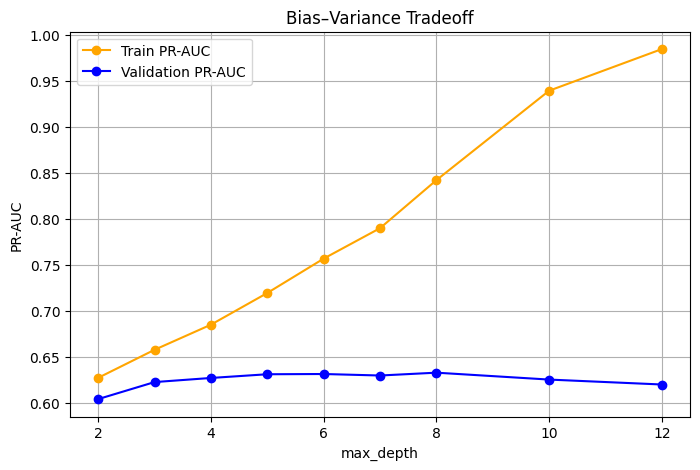

In [10]:
depth_values = [2, 3, 4, 5, 6, 7, 8, 10, 12]

train_scores = []
test_scores = []

for depth in depth_values:
    model = CatBoostClassifier(cat_features=cat_cols, iterations=800, depth=depth, l2_leaf_reg=10, learning_rate=0.05, subsample=0.8, scale_pos_weight=7, random_state=42, verbose=0)
    model.fit(X_train, y_train, cat_features=cat_cols, verbose=0)

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]

    train_scores.append(average_precision_score(y_train, y_train_pred))
    test_scores.append(average_precision_score(y_test, y_test_pred))

plt.figure(figsize=(8, 5))
plt.plot(depth_values, train_scores, marker='o', label='Train PR-AUC', color='orange')
plt.plot(depth_values, test_scores, marker='o', label='Validation PR-AUC', color='blue')
plt.xlabel('max_depth')
plt.ylabel('PR-AUC')
plt.title('Bias–Variance Tradeoff')
plt.legend()
plt.grid(True)

An analysis of the relationship between model quality and tree depth and the number of iterations (Bias–Variance Tradeoff) was conducted.
With increasing tree depth, an increase in the PR-AUC metric is observed on the training set. However, after a depth of 8, the validation quality begins to decline, indicating the onset of overfitting.
Similarly, increasing the number of trees improves the training quality but does not yield a significant improvement on the test set.

In [49]:
model = CatBoostClassifier(cat_features=cat_cols, iterations=800, depth=6, l2_leaf_reg=5, learning_rate=0.05, subsample=0.8, scale_pos_weight=7, random_state=42, verbose=0)
model.fit(X_train, y_train)
average_precision_score(y_test, model.predict_proba(X_test)[:, 1])

0.6386493801696567

In [32]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))
evals_result = model.get_evals_result()
evals_result.keys()

dict_keys(['learn', 'validation'])

To monitor the dynamics of training and check for overfitting, I visualize the training curve. The test dataset is used as a validation set.

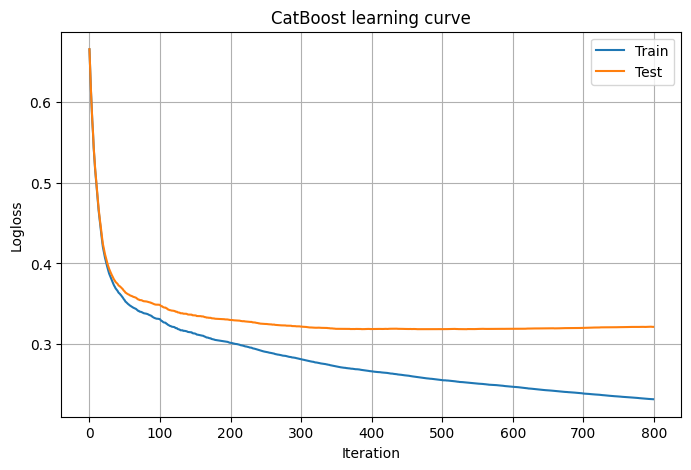

In [110]:
plt.figure(figsize=(8, 5))
plt.plot(evals_result['learn']['Logloss'], label='Train')
plt.plot(evals_result['validation']['Logloss'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('CatBoost learning curve')
plt.legend()
plt.grid(True);

The CatBoost training plot shows the change in the loss function (Logloss) on the training and test sets over boosting iterations.

At the beginning of training, Logloss is observed to decrease sharply, indicating rapid improvement in model performance. After approximately 200 iterations, the test curve reaches a plateau, indicating a steady state of training.

The error lines on the training and test sets are close to each other, indicating the absence of significant overfitting.

In [34]:
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

train_scores, test_scores = [], []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train, cat_features=cat_cols, verbose=0)
    train_scores.append(average_precision_score(y_train, model.predict_proba(X_train)[:, 1]))
    test_scores.append(average_precision_score(y_test, model.predict_proba(X_test)[:, 1]))

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)

print(f"Train mean: {train_scores.mean():.3f} ± {train_scores.std():.3f}")
print(f"Test  mean: {test_scores.mean():.3f} ± {test_scores.std():.3f}")

Train mean: 0.746 ± 0.005
Test  mean: 0.641 ± 0.011


To assess model stability and test the bias-to-variance ratio, cross-validation was conducted with 20 random stratified splits.
For each split, the PR-AUC was calculated for the training and test sets.
The mean values were 0.746 ± 0.005 for the train set and 0.641 ± 0.011 for the test set.

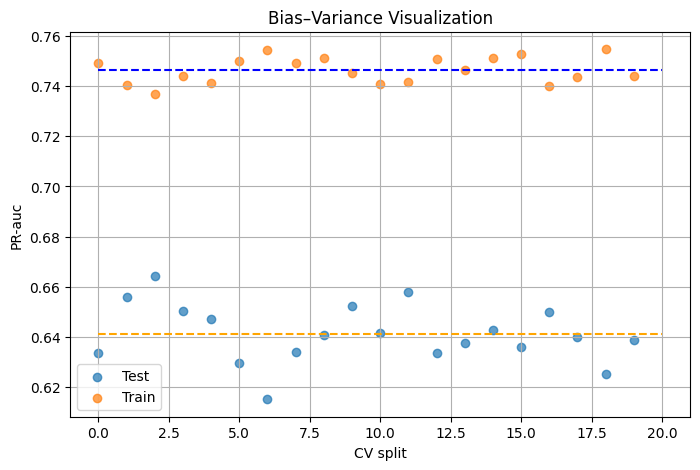

In [35]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(test_scores)), test_scores, label='Test', alpha=0.7)
plt.scatter(range(len(train_scores)), train_scores, label='Train', alpha=0.7)
plt.hlines(np.mean(train_scores), 0, len(train_scores), colors='blue', linestyles='dashed')
plt.hlines(np.mean(test_scores), 0, len(test_scores), colors='orange', linestyles='dashed')
plt.legend()
plt.xlabel('CV split')
plt.ylabel('PR-auc')
plt.title('Bias–Variance Visualization')
plt.grid(True)

The dashed lines represent the average metric level and reflect bias.
The scatter of dots reflects variance.

The visualization shows a moderate gap between the training and testing performance, indicating minor overfitting with fairly stable results across splits.
This means that the model generally generalizes adequately.

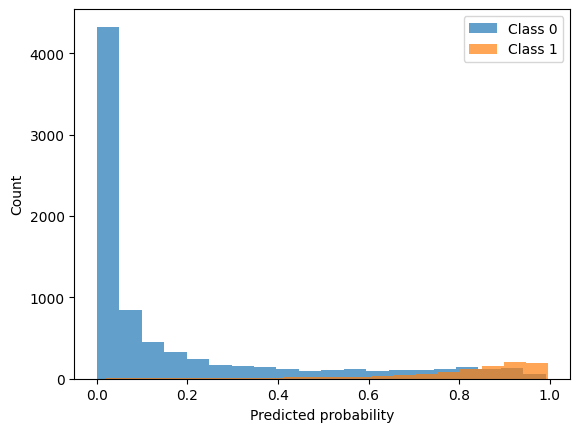

In [37]:
y_proba = model.predict_proba(X_test)[:, 1]
plt.hist(y_proba[y_test == 0], bins=20, alpha=0.7, label='Class 0')
plt.hist(y_proba[y_test == 1], bins=20, alpha=0.7, label='Class 1')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend();

The model has high confidence in recognizing class 0 but low confidence in class 1, which is typical for imbalanced classification problems.
This distribution shape also explains why the PR-AUC metric remains moderate with a small number of true positive observations, the model is cautious in its positive predictions.

Try undersampling/oversampling.

In [38]:
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

smotenc = SMOTENC(categorical_features=cat_idx, random_state=25)

X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)
model_resampled = CatBoostClassifier(cat_features=cat_cols, iterations=800, depth=6, l2_leaf_reg=5, learning_rate=0.05, subsample=0.8, scale_pos_weight=7, random_state=42, verbose=0)

model_resampled.fit(X_resampled, y_resampled, verbose=0)

In [39]:
average_precision_score(y_test, model_resampled.predict_proba(X_test)[:, 1])

0.5945628778813596

In [42]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)
model_resampled = CatBoostClassifier(cat_features=cat_cols, iterations=800, depth=6, l2_leaf_reg=5, learning_rate=0.05, subsample=0.8, scale_pos_weight=7, random_state=42, verbose=0)

model_resampled.fit(X_resampled, y_resampled, verbose=0)

In [43]:
average_precision_score(y_test, model_resampled.predict_proba(X_test)[:, 1])

0.6138794668513895

After class balancing using oversampling (SMOTENC) and undersampling (RandomUnderSampler), the same CatBoost model was trained with the same hyperparameters.

However, the PR-AUC metric decreased.

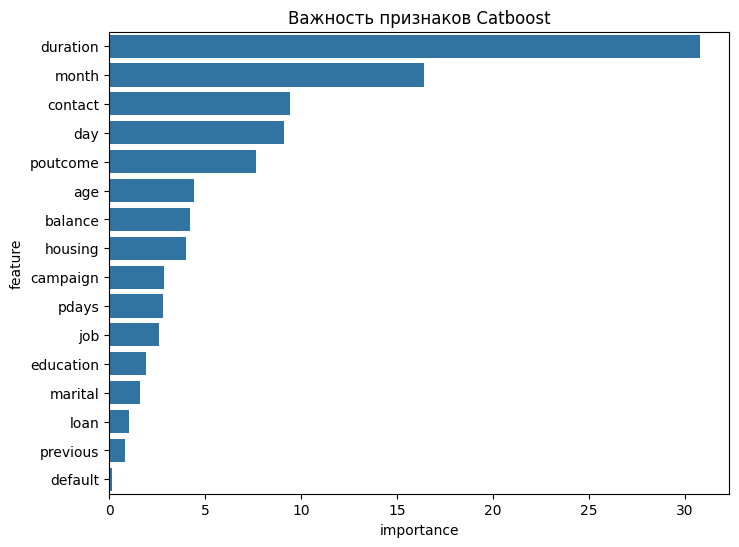

In [45]:
importances = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_cols))
features_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
features_importances_df = features_importances_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(data=features_importances_df, x='importance', y='feature')
plt.title('Важность признаков Catboost');

In [46]:
features_importances_df.head()

,feature,importance
11,duration,30.760671
10,month,16.429715
8,contact,9.436446
9,day,9.139817
15,poutcome,7.674129


The get_feature_importance method shows which features were most frequently used when splitting boosting nodes.
The top three were "duration" (conversation duration) - the longer the conversation, the greater the person's interest in opening a deposit.
"month" (month) was also significant, possibly due to seasonal fluctuations.
"contact" (method of communication) was also significant, possibly because clients contacted by mobile were more accessible.

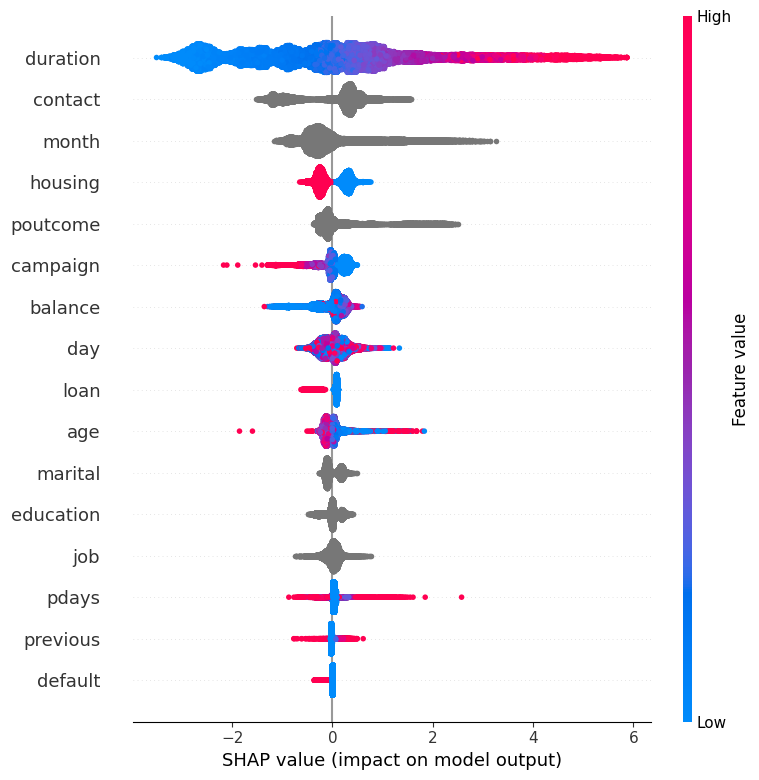

In [47]:
shap_values = model.get_feature_importance(Pool(X_train, y_train, cat_features=cat_cols), type='ShapValues')
shap.summary_plot(shap_values[:, :-1], X_train)

Shap shows which features and how (positively or negatively) influence the prediction. The top three remain unchanged.

## The best configuration

After trying different models using RandomizedSearchCV, the Boosting model showed the best results.
I settled on CatBoost as the most stable. I then narrowed the hyperparameter space
and performed a more precise fitting using GridSearchCV.

Best configuration:

* iterations = 800
* learning_rate = 0.05, a small step size, which makes training slower but more stable (compensated by the large number of trees)
* max_depth = 6, trees not too deep to avoid overfitting, but not too shallow to capture structure in the data.
* l2_leaf_reg = 5, L2 regularization, medium value.
* scale_pos_weight = 7, an important parameter in our case (with unbalanced classes), balances the importance of classes -
increases the error weight of the minor class. This helps the model better detect the rare class.
* subsample = 0.8, the proportion of the training sample for each tree (bootstrap), adds stochasticity, reduces the risk of overfitting.

# Model quality assessment

## Model metrics

In [90]:
y_proba = model.predict_proba(X_test)[:,1]
y_predicts = model.predict(X_test)

In [91]:
f'accuracy: {accuracy_score(y_test, y_predicts)}, precision: {precision_score(y_test, y_predicts)}, recall: {recall_score(y_test, y_predicts)}' \
f' f1_score: {f1_score(y_test, y_predicts)}, roc_auc: {roc_auc_score(y_test, y_proba)}, precision-recall_auc: {average_precision_score(y_test, y_proba)}'

'accuracy: 0.8629879464779387, precision: 0.45535273803650717, recall: 0.8724007561436673 f1_score: 0.5983792544570502, roc_auc: 0.9384388024332012, precision-recall_auc: 0.6386493801696567'

* Accuracy (classification accuracy) = 0.86. This isn't a reliable metric in this case (due to imbalance), but it's a basic metric—it shows the proportion of correctly classified objects.
* Precision (accuracy for the positive class) = 0.45. Of all the observations predicted as class 1, only 45% actually belong to class 1. With high Precision, the model produces fewer false positives, which is especially important if the cost of false positives is high.
* Recall (recall) = 0.87. The model correctly identified 87% of all positive objects. If it's important not to miss rare positive cases, Recall has a high priority.
* f1_score (harmonic mean of Precision and Recall) = 0.6. Well, the model performs better than random guessing.
* roc_auc (reflects the model's ability to distinguish between classes at all thresholds) = 0.94, meaning the probability that the model will assign a higher score to a random positive example than to a random negative example is 94%.
* precision-recall_auc (a more informative metric for class imbalance than roc_auc) = 0.64, meaning the model maintains a moderate precision/recall ratio at different thresholds.

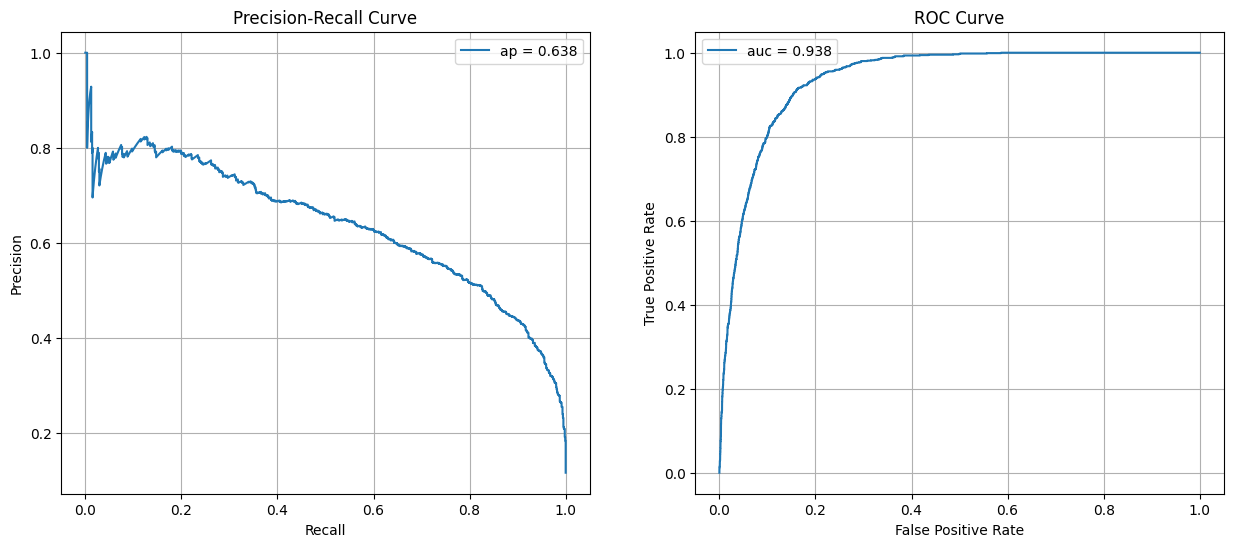

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = auc(recall, precision)
axes[0].plot(recall, precision, label=f'ap = {ap:.3f}')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[0].set_title('Precision-Recall Curve')
axes[0].grid()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, label=f'auc = {roc_auc:.3f}')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()
axes[1].set_title('ROC Curve')
axes[1].grid();

The model distinguishes between classes well and allows, if necessary, to manage the strategy depending on the business goals.

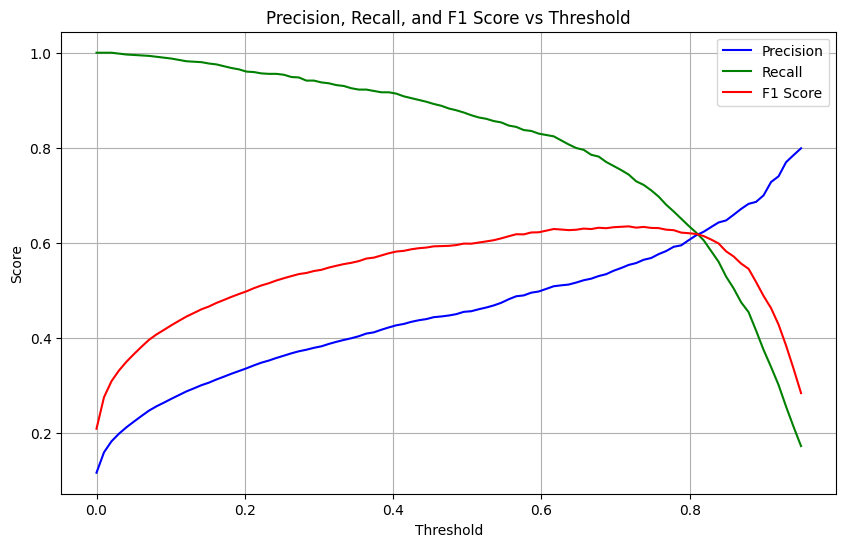

In [93]:
thresholds = np.linspace(0, 0.95, 95)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.legend()
plt.grid(True);

Precision, Recall, and F1-score vs. Threshold - this plot shows how the model's behavior changes as the probability threshold at which an observation is considered class 1 changes.

The dilemma between precision and recall.

If the goal is to optimize marketing spend, you can increase the classification threshold to improve precision, thereby focusing efforts only on those customers who are likely to actually sign a contract.

If the goal is to maximize customer retention and minimize losses, you can lower the threshold to increase recall, even if some of the positives turn out to be false positives.

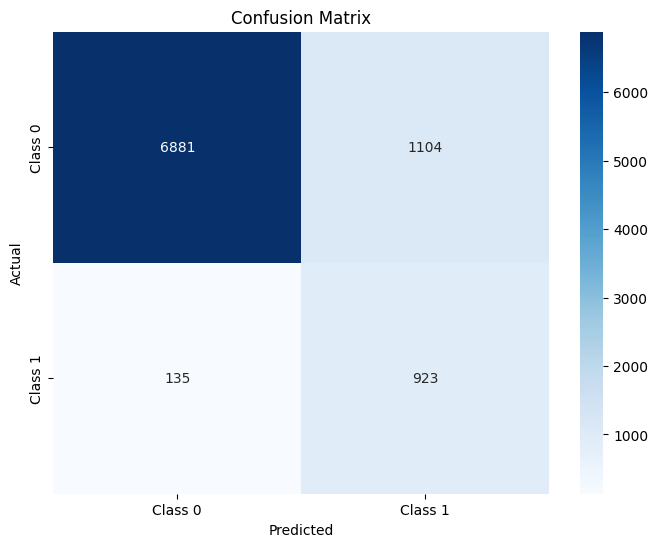

In [94]:
y_predicts = (y_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_predicts)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

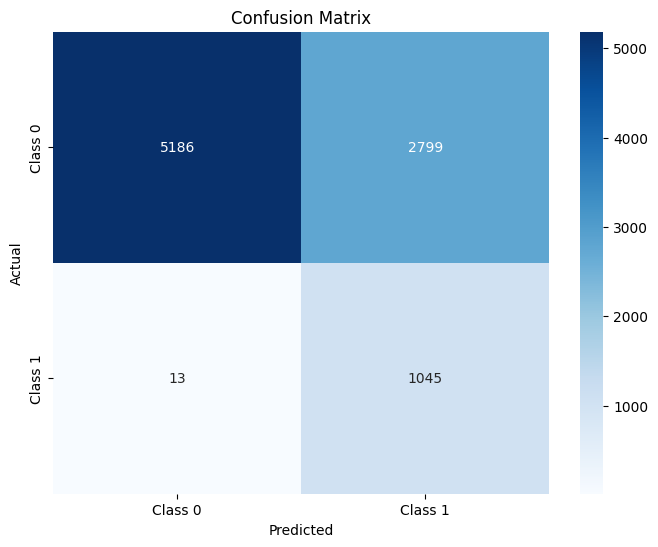

In [95]:
y_predicts = (y_proba >= 0.1).astype(int)
cm = confusion_matrix(y_test, y_predicts)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix');

## Business effect evaluation

To evaluate the model's impact on business, the following metrics were selected:
* Conversion Rate – the proportion of customers who agreed to open a deposit after the call.
* Profit – a metric reflecting the economic value of the model.
* Lift Analysis – an analysis of how metrics change when calling only the portion of customers with the highest likelihood of agreement (as predicted by the model).

### Conversion

In [96]:
y_proba = model.predict_proba(X_test)[:,1]
y_predicts = (y_proba >= 0.1).astype(int)

In [97]:
y_test.sum(), y_predicts.sum()

(np.int64(1058), np.int64(3844))

In [111]:
conversion = y_test.sum() / len(y_test)
conversion_model = ((y_predicts == 1) & (y_test == 1)).sum() / y_predicts.sum()
print(f'Conversion without using a model: {conversion:.2f}')
print(f'Conversion among clients selected by the model: {conversion_model:.2f}')

Conversion without using a model: 0.12
Conversion among clients selected by the model: 0.27


Conversion without the model is 12%. After implementing the model, operators can focus on customers with the highest likelihood of responding, increasing conversion among this group to 27%.

Therefore, using the model allows for a reduction in call volume and a nearly twofold increase in marketing campaign effectiveness.

### Profit 

In [113]:
thresholds = np.linspace(0.1, 1.0, 10)
profits = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    N = y_pred.sum()
    n_accept = ((y_pred == 1) & (y_test == 1)).sum()
    profit = (n_accept * deposit_profit) - (N * call)
    profits.append(profit)

best_idx = np.argmax(profits)
best_thr = thresholds[best_idx]
best_profit = profits[best_idx]
print(f"Best profit threshold: {best_thr:.1f}, profit = {best_profit:.0f}")

Best profit threshold: 0.1, profit = 100656


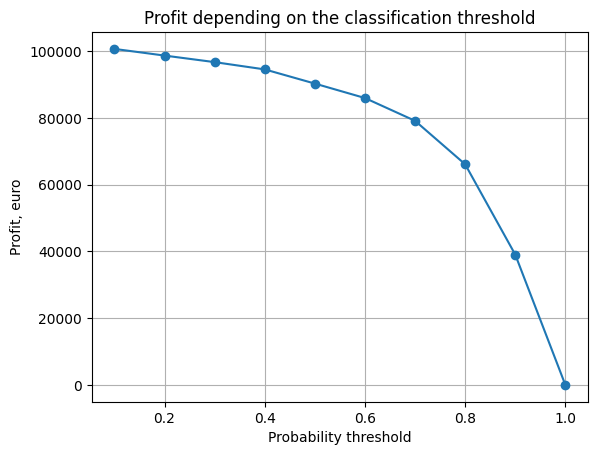

In [114]:
plt.plot(thresholds, profits, marker='o')
plt.xlabel('Probability threshold')
plt.ylabel('Profit, euro')
plt.title('Profit depending on the classification threshold')
plt.grid(True);

In [115]:
call = 1
deposit_profit = 100
N = len(y_test)
n_accept = y_test.sum()

profit_without_model = (n_accept * deposit_profit) - (N * call)
print(f"Without a model, a marketing company's profit is {profit_without_model:.0f} евро")

Without a model, a marketing company's profit is 96757 евро


In [116]:
call = 1
deposit_profit = 100
N = y_predicts.sum()
n_accept = ((y_predicts == 1) & (y_test == 1)).sum()

profit_with_model = (n_accept * deposit_profit) - (N * call)
print(f"After implementing the model, the marketing company's profit is {profit_with_model:.0f} euro")

After implementing the model, the marketing company's profit is 100656 euro


In [101]:
len(y_test), y_predicts.sum()

(9043, np.int64(3844))

### Ranking effect

In [104]:
q = pd.DataFrame({'y_true': y_test, 'y_proba': y_proba})
q = q.sort_values(by='y_proba', ascending=False).reset_index(drop=True)
q['decile'] = pd.qcut(q.index, 10, labels=False)
lift_table = q.groupby('decile').agg(
    total=('y_true', 'count'),
    positives=('y_true', 'sum')
).reset_index()
lift_table['conversion'] = lift_table['positives'] / lift_table['total']
baseline = q['y_true'].mean()
lift_table['lift'] = lift_table['conversion'] / baseline
lift_table

,decile,total,positives,conversion,lift
0,0,905,584,0.645304,5.515579
1,1,904,302,0.334071,2.855390
2,2,904,118,0.130531,1.115682
3,3,904,35,0.038717,0.330923
4,4,905,13,0.014365,0.122778
5,5,904,4,0.004425,0.037820
6,6,904,2,0.002212,0.018910
7,7,904,0,0.000000,0.000000
8,8,904,0,0.000000,0.000000
9,9,905,0,0.000000,0.000000


If we only call clients in the top 10%,
we get a conversion rate of around 65%—super effective!
If we call everyone (baseline), the conversion rate is only 12%.
For the remaining groups, conversion rates drop quickly, so there's no point in wasting resources on cold leads.

The model ranks clients well by response probability.
For the top 10% of clients, the deposit conversion rate reaches almost 65%, which is 5.5 times higher than the sample average (12%).
This allows agents to focus their efforts on the most promising clients and significantly improve the effectiveness of their marketing campaign.

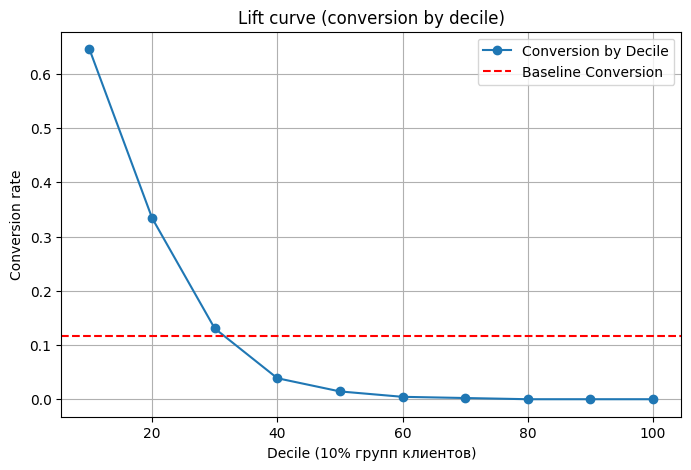

In [105]:
plt.figure(figsize=(8,5))
plt.plot((lift_table['decile'] + 1) * 10,
         lift_table['conversion'], 
         marker='o', label='Conversion by Decile')
plt.axhline(y=baseline, color='red', linestyle='--', label='Baseline Conversion')
plt.xlabel('Decile (10% групп клиентов)')
plt.ylabel('Conversion rate')
plt.title('Lift curve (conversion by decile)')
plt.legend()
plt.grid(True);

In [117]:
lift_table['profit'] = (lift_table['positives'] * deposit_profit) - (lift_table['total'] * call)

top_n = 5
top_profit = lift_table[lift_table['decile'] < top_n]['profit'].sum()

print(f'Profit from calling top-{top_n*10}% clients: {top_profit:.0f} euro')

Profit from calling top-50% clients: 100678 euro


In [108]:
y_predicts.sum()/2

np.float64(1922.0)

This allows you to compare profits for different options—calling everyone (all 10 deciles) or just the top 30%, top 50%, etc.
This will help demonstrate how much more cost-effective and efficient it is to work with the model and focus calls on hot clients.

Thus, the top 50% profit is €100 678, given that the number of calls is 1922, compared to €96 757 without the model and 9043 calls.

# Final Summary

The goal of this project was to optimize the cold-calling process for a marketing campaign aimed at attracting clients to deposit products.
A machine learning model was developed to predict the likelihood that a client would agree to open a deposit after a phone call.

The model significantly improved the campaign’s efficiency. The conversion rate among the targeted clients increased from 12% to 27%, which is more than twice the baseline level. At the same time, the campaign’s profit rose from €96,757 to €100,656, confirming the economic benefit of using the model.

The model also shows strong ranking performance: within the top 10% of clients, the conversion rate reaches 65%, which is 5.5 times higher than the average. This allows operators to focus on the most promising clients, reduce the total number of calls, and improve the overall return of the marketing effort.

In conclusion, the implementation of the predictive model leads to a notable increase in both efficiency and profitability, making the marketing campaign more data-driven and resource-effective.